# Intro

Notebook contains some examples of how to analyze our sweeps and also our results as of Aug 23. 

results tldr: Chils is strong. We may have gains in geo datasets, but they are not super consistent ... we need to improve our method.  

positive note: we have great tools to do so. We can run many experiments and inspect these results (hopefully) easily.

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
  %reload_ext autoreload

# Baselines

To load baselines, use analyzer.baseline_numbers(), as shown below. 

In [1]:
from analysis import Analyze
analyzer = Analyze()
baselines = analyzer.baseline_numbers()

100%|██████████| 64/64 [00:00<00:00, 195.02it/s]


In [2]:
baselines

,dsetname,method,accuracy,worst class accuracy,avg worst 20th percentile class accs,average worst subpop accuracy,Asia,Europe,Americas,Africa,EastAsia,SouthEastAsia,WestAsia,poor,lower middle class,upper middle class,rich
0,dollarstreet__region,vanilla,42.681932,3.413886,12.938486,34.464942,41.655451,52.087576,45.128205,33.933476,NaN,NaN,NaN,27.922236,39.770723,50.496729,52.189282
1,entity13,vanilla,68.219231,29.750000,34.383333,21.769231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,entity30,vanilla,68.433333,15.375000,32.500000,36.266667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,geode__region,vanilla,90.336785,35.481707,71.626075,83.490199,NaN,92.387268,91.216636,87.286481,90.353090,90.590935,90.678547,NaN,NaN,NaN,NaN
4,living17,vanilla,92.955882,63.500000,74.000000,82.235294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,mit_states_0.8,vanilla,78.240029,24.323830,52.115447,53.826813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,mit_states_0.9,vanilla,59.070966,0.333333,26.787722,29.488497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nonliving26,vanilla,77.269231,24.750000,49.150000,57.115385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,dollarstreet__region,dclip,42.180854,3.797468,12.847373,33.462720,41.480485,50.899525,44.558405,33.384193,NaN,NaN,NaN,27.484812,39.384921,50.314999,51.208666
9,entity13,dclip,68.642308,26.800000,36.483333,22.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plotting

We have a general plotter as well. It is intended to allow you to compare values for one column (e.g. baseline method).

It generates two plots: 
- a massive one w/ a sub barplot for every metric, a set of bars for every dataset, and a bar for every col_to_compare X dataset X metric
- a condensed one that averages over datasets, so it shows a subplot per metric and a bar per col_to_compare

Below we use the general plotting to compare our baseline methods. CHiLs is the best (take a look at the second set of plots).

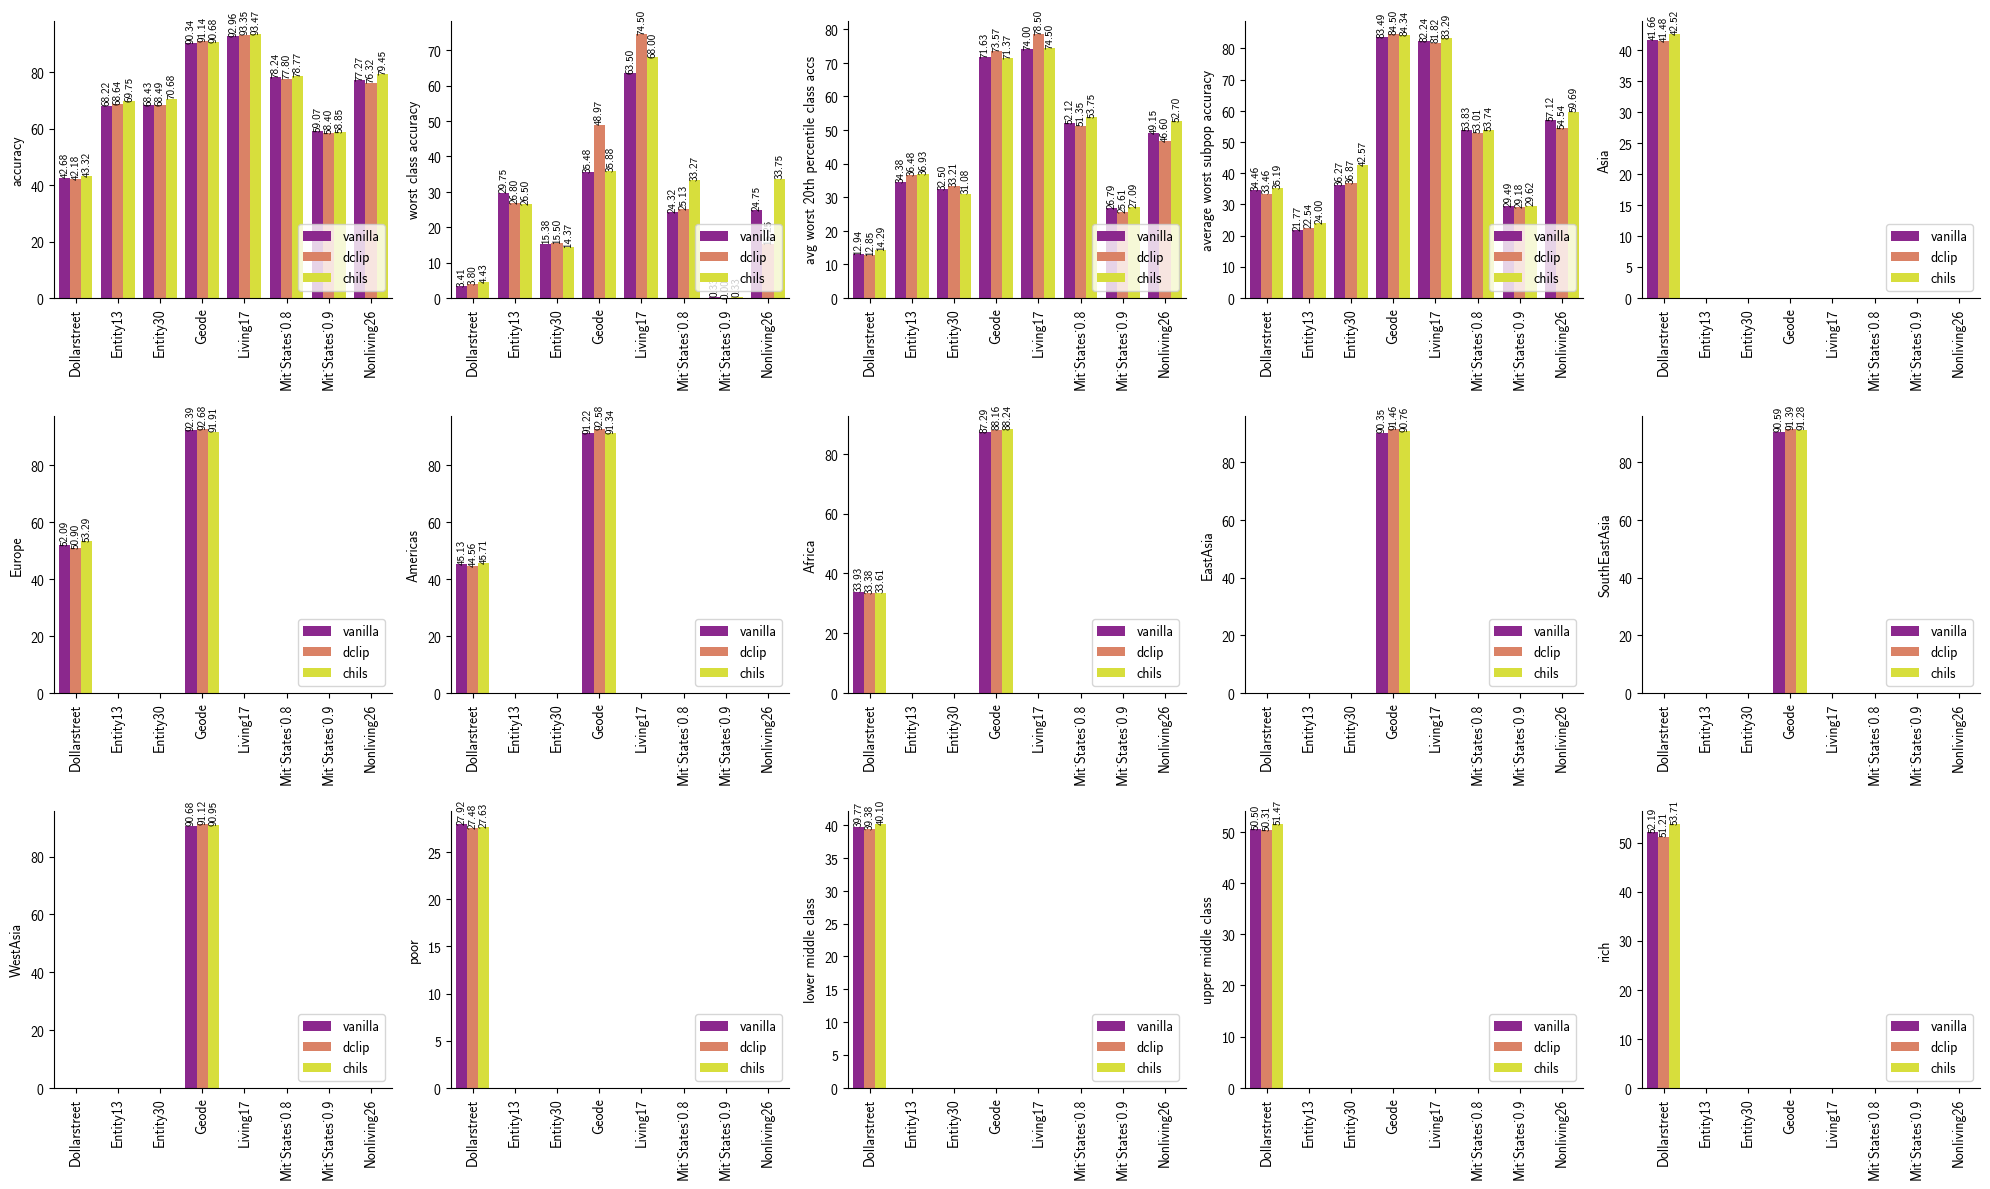

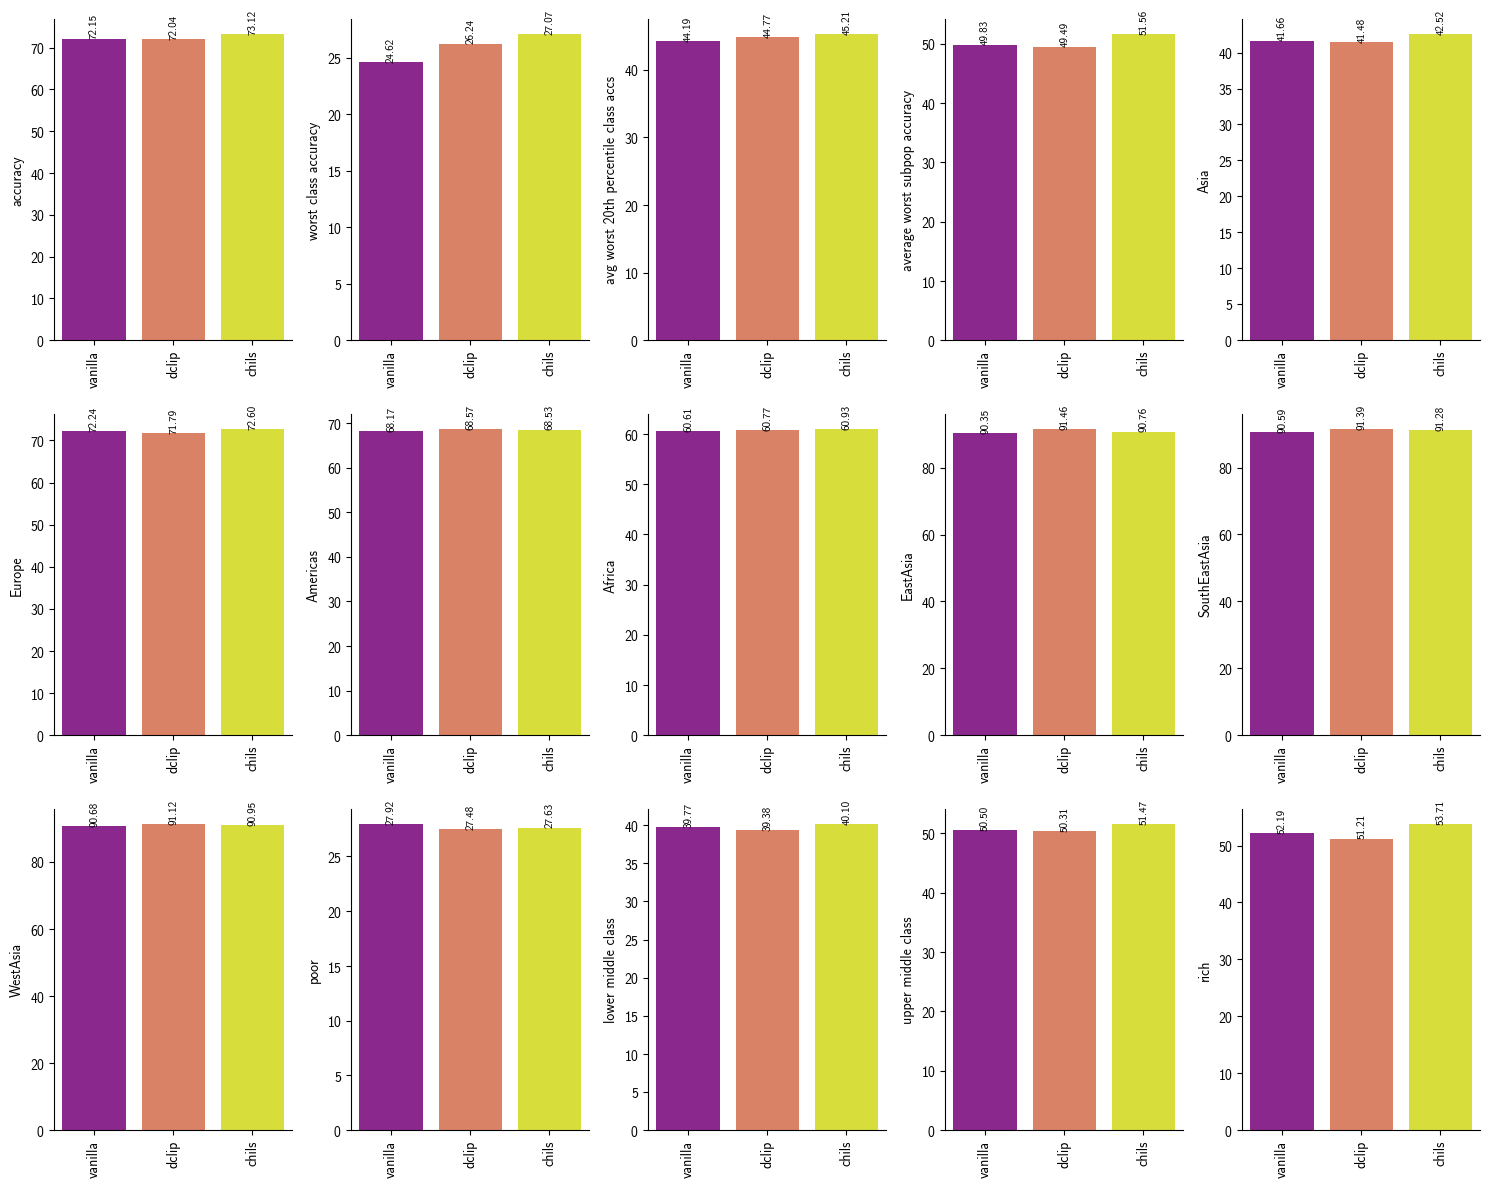

In [99]:
f = analyzer.general_plotter(
    results_df = baselines, 
    col_to_compare = 'method',
    col_to_compare_vals = ['vanilla', 'dclip', 'chils'],
    save_fname = 'baselines',
)

# Loading our results so we can slice+dice

Now we'll load some of our results. We'll demonstrate a function called best_runs_given_metric, which allows us to better get a sense of what's working, and also show another example of using the plotting code. 

## Loading our results

Note that the following boolean flag in collect_jsons_for_sweep is turned **on**: `do_not_return_preds: bool=True`. This is to speed up consolidating jsons (returning and carrying around thousands of predictions per run X thousands of runs makes things slow). 

I haven't implemented this yet, but we can easily tack on the json file path with all info to the dataframe collect_jsons_for_sweep returns, so that we can delve deeper into a specific run if we'd like. For now, nearly all the metrics we care about are computed during the sweep and loaded ... lmk if something is missing.

The big results sweep has `log_dir='aug23_all'`. A smaller one with just the geographic datasets (and I'm realizing now a couple more attributers that didn't seem very successful: country, region) has log_dir = `'aug23_geographic'`. We load both below. First one may take a min or so, so feel free to comment out if you don't want to use it. 


In [100]:
ours_df = analyzer.collect_jsons_for_sweep('aug23_all')
ours_geo_df = analyzer.collect_jsons_for_sweep('aug23_geographic')

  1%|          | 84/10550 [00:00<00:55, 190.18it/s]

100%|██████████| 992/992 [00:05<00:00, 190.72it/s]


## Inspecting results

`analyzer.best_runs_given_metric` let's us see whats best. By default, it will average away VLM and datasets. Example below. 

This example also reveals our dilemma: we are not beating CHiLs when we average over everything and sort by accuracy. Note that we do include 4 datasets (breeds) that are very well suited to CHiLs. Also note that the lamb parameter only means something when predictor is interpol. `lamb=0` for `interpol_sims_top_32` means only use top 32 sims, `lamb=1` means only use average sims.

In [101]:
analyzer.best_runs_given_metric(ours_df)

,attributer_keys,vlm_prompts,predictor,vlm_prompt_dim_handler,lamb,accuracy,worst class accuracy,avg worst 20th percentile class accs,average worst subpop accuracy,Asia,Europe,Americas,Africa,EastAsia,SouthEastAsia,WestAsia,poor,lower middle class,upper middle class,rich
334,"['vanilla', 'llm_kinds_chils']",['USE OPENAI IMAGENET TEMPLATES'],chils,average_and_norm_then_stack,0.00,73.113149,27.067810,45.228815,51.519386,42.570659,72.499374,68.498026,60.834066,90.762926,91.279403,90.952707,27.545565,40.057319,51.453841,53.614595
224,"['vanilla', 'llm_kinds']",['USE OPENAI IMAGENET TEMPLATES'],chils,average_and_norm_then_stack,0.00,72.931848,27.633591,45.288612,51.106838,41.944818,72.370606,68.101235,61.331305,90.384615,91.681010,91.295408,27.910085,38.944004,50.702690,52.166477
118,"['vanilla', 'llm_dclip']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_16,average_and_norm_then_stack,0.75,72.813842,27.992920,45.875336,50.797599,41.487214,71.806257,68.548958,60.797462,91.456494,91.394148,91.124058,27.533414,39.351852,50.351345,51.197263
116,"['vanilla', 'llm_dclip']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_16,average_and_norm_then_stack,0.25,72.806850,27.992920,45.878569,50.783535,41.500673,71.721396,68.534713,60.736431,91.456494,91.394148,91.124058,27.533414,39.395944,50.254422,51.037628
117,"['vanilla', 'llm_dclip']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_16,average_and_norm_then_stack,0.50,72.804639,27.992920,45.876839,50.786583,41.453567,71.763827,68.513346,60.736431,91.456494,91.394148,91.124058,27.484812,39.285714,50.302883,51.094641
10,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_16,stack_all,0.25,72.583139,27.544050,45.061980,49.890994,42.886945,71.434904,67.668712,61.360592,89.943253,90.533563,90.507197,29.890644,40.200617,50.763266,51.812999
51,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_8,stack_all,0.50,72.576125,27.335248,44.886375,50.014651,42.994616,71.329362,67.790312,61.601661,89.943253,90.476190,90.438657,30.085055,40.376984,50.799612,51.824401
35,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_4,stack_all,0.50,72.563202,27.324081,44.875291,49.955775,42.960969,71.440748,67.724936,61.548232,89.722573,90.562249,90.712817,29.890644,40.465168,50.642113,51.870011
26,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_32,stack_all,0.25,72.562415,27.424008,45.006217,50.051185,42.880215,71.437547,67.723663,61.473537,90.037831,90.562249,90.678547,30.097205,40.399030,50.666344,51.835804
444,"['vanilla', 'llm_kinds_regions_incomes']",['USE OPENAI IMAGENET TEMPLATES'],chils,average_and_norm_then_stack,0.00,72.557811,26.269168,45.538565,50.083404,41.514132,72.469189,67.801533,60.368883,89.375788,91.308090,91.432488,27.339004,39.263668,51.041919,51.995439


To not be so defeatist (and to show more usage), we can focus on some places where we have gains. If you sort by accuracy for images taken in the region Africa, our methods are at the top of the list. Note that this metric is only computed for dollarstreet and geode datasets; is NaN for all others. Fortunately, pandas seems to do nanmean by default.

In [102]:
analyzer.best_runs_given_metric(ours_df, metric_to_sort_by='Africa')

,attributer_keys,vlm_prompts,predictor,vlm_prompt_dim_handler,lamb,accuracy,worst class accuracy,avg worst 20th percentile class accs,average worst subpop accuracy,Asia,Europe,Americas,Africa,EastAsia,SouthEastAsia,WestAsia,poor,lower middle class,upper middle class,rich
51,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_8,stack_all,0.50,72.576125,27.335248,44.886375,50.014651,42.994616,71.329362,67.790312,61.601661,89.943253,90.476190,90.438657,30.085055,40.376984,50.799612,51.824401
19,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_2,stack_all,0.50,72.536246,27.408157,44.785257,49.932415,43.068641,71.469916,67.758002,61.589408,89.848676,90.619621,90.815627,29.878493,40.542328,50.775382,52.006842
15,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_2,average_and_norm_then_stack,0.50,72.432344,27.350594,44.707599,50.032637,42.705249,71.725056,68.019028,61.560434,90.416141,91.021228,90.884167,29.756987,40.553351,50.460383,51.755986
35,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_4,stack_all,0.50,72.563202,27.324081,44.875291,49.955775,42.960969,71.440748,67.724936,61.548232,89.722573,90.562249,90.712817,29.890644,40.465168,50.642113,51.870011
53,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],max_of_max,average_and_norm_then_stack,0.00,72.306048,26.271736,44.401361,49.926966,42.523553,71.644414,68.207516,61.523804,90.100883,90.619621,90.918437,29.963548,40.046296,50.654228,51.915621
16,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_2,average_and_norm_then_stack,0.75,72.417290,27.376502,44.692019,50.108409,42.563930,71.770688,67.900731,61.507031,90.353090,91.164659,90.849897,29.599028,40.421076,50.375575,51.790194
27,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_32,stack_all,0.50,72.515759,27.149933,44.742932,49.994780,43.075370,71.642838,67.646588,61.479650,90.226986,90.332760,90.815627,30.255164,40.376984,50.799612,51.892816
26,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_32,stack_all,0.25,72.562415,27.424008,45.006217,50.051185,42.880215,71.437547,67.723663,61.473537,90.037831,90.562249,90.678547,30.097205,40.399030,50.666344,51.835804
2,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],average_vecs,average_and_norm_then_stack,1.00,72.400225,27.685822,44.805266,50.007033,42.449529,71.713928,67.824930,61.467345,90.416141,91.135972,90.952707,29.368165,40.354938,50.399806,51.550741
31,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_4,average_and_norm_then_stack,0.50,72.363806,27.347336,44.577947,49.966511,42.530283,71.706508,67.839175,61.459742,90.321564,90.849111,90.849897,29.562576,40.376984,50.230191,51.698974


And we can average away other things. Whatever you don't put in `inputs_to_show` is averaged away. By default, `inputs_to_show=['attributer_keys', 'vlm_prompts', 'predictor', 'vlm_prompt_dim_handler', 'lamb']`. Let's try something else.

In [103]:
analyzer.best_runs_given_metric(ours_df, inputs_to_show=['predictor', 'lamb'])

,predictor,lamb,accuracy,worst class accuracy,avg worst 20th percentile class accs,average worst subpop accuracy,Asia,Europe,Americas,Africa,EastAsia,SouthEastAsia,WestAsia,poor,lower middle class,upper middle class,rich
2,chils,0.00,71.831844,24.828947,44.047076,49.669268,41.238784,71.789583,67.726859,60.273811,90.127154,91.004494,91.164039,27.447347,38.922876,50.015144,51.647662
9,interpol_sims_top_2,0.50,71.440141,23.759457,43.337637,49.245042,40.922779,71.306768,67.263125,59.842894,90.153426,90.645917,90.732808,27.272681,38.494360,49.533055,50.952585
17,interpol_sims_top_4,0.50,71.370800,23.620537,43.146451,49.213110,40.953062,71.248513,67.245168,59.784247,90.242749,90.521610,90.677119,27.246861,38.577950,49.544160,50.899848
16,interpol_sims_top_4,0.25,71.359030,24.162146,43.409377,49.130107,40.595559,71.132047,67.102869,59.715592,90.127154,90.613645,90.739947,26.946638,38.113610,49.278128,50.589605
8,interpol_sims_top_2,0.25,71.283366,24.414980,43.539114,49.066595,40.326660,70.988640,66.979893,59.598549,89.897278,90.617231,90.659984,26.749696,37.773736,48.945966,50.377708
10,interpol_sims_top_2,0.75,71.237712,23.001219,42.737141,49.104066,40.974372,71.222447,67.187871,59.651262,90.110078,90.305269,90.458647,27.321790,38.682209,49.564857,50.903649
18,interpol_sims_top_4,0.75,71.185778,22.876916,42.615061,49.077796,40.918854,71.120542,67.136876,59.572643,90.071984,90.243115,90.470071,27.248380,38.651437,49.494185,50.808628
24,interpol_sims_top_8,0.25,71.176824,23.664728,42.912201,48.989305,40.651638,70.986467,67.010416,59.598124,90.064103,90.422404,90.667124,27.028149,38.298703,49.210484,50.477480
25,interpol_sims_top_8,0.50,71.176593,23.180027,42.748047,49.013569,40.884085,71.071415,67.126102,59.630205,90.144231,90.333955,90.562886,27.222560,38.576113,49.432598,50.717408
1,average_vecs,1.00,71.088735,23.523020,42.843394,48.912892,40.718091,71.334051,67.231389,59.864591,90.552753,90.767833,90.765650,27.202309,38.554067,49.206950,50.570125


We can specify a dataset too, as well as the number of rows to show. Let's compare chils on dollarstreet to our best on dollarstreet. Note that we can choose which metrics to show in case you don't want to be overwhelmed.

In [104]:
analyzer.best_runs_given_metric(ours_df, dsetname='dollarstreet__region', metric_to_sort_by='poor', metrics_to_show=['poor', 'accuracy', 'average worst subpop accuracy'], num_to_show=10)

,attributer_keys,vlm_prompts,predictor,vlm_prompt_dim_handler,lamb,poor,accuracy,average worst subpop accuracy
27,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_32,stack_all,0.50,30.255164,43.398590,35.201778
43,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_64,stack_all,0.50,30.182260,43.267494,35.034512
26,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_32,stack_all,0.25,30.097205,43.319932,35.017833
51,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_8,stack_all,0.50,30.085055,43.340325,35.048658
12,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_16,stack_all,0.75,30.085055,43.264581,35.136474
11,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_16,stack_all,0.50,30.060753,43.217969,35.038348
44,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_64,stack_all,0.75,30.048603,43.229622,35.130939
42,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_64,stack_all,0.25,30.012151,43.273321,35.033448
41,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_64,stack_all,0.00,30.012151,43.171357,34.825369
28,"['vanilla', 'income_level']",['USE OPENAI IMAGENET TEMPLATES'],interpol_sims_top_32,stack_all,0.75,30.000000,43.241275,35.148076


The function that loaded baseline numbers averages away most axes. You can load each individual baseline without averaging as well, as done below. 

In [105]:
chils_df = analyzer.load_baseline('chils')
analyzer.best_runs_given_metric(chils_df, dsetname='dollarstreet__region', metric_to_sort_by='poor', metrics_to_show=['poor', 'accuracy', 'average worst subpop accuracy'])

100%|██████████| 64/64 [00:00<00:00, 185.76it/s]


,attributer_keys,vlm_prompts,predictor,vlm_prompt_dim_handler,lamb,poor,accuracy,average worst subpop accuracy
0,"['vanilla', 'llm_kinds_chils']",['USE OPENAI IMAGENET TEMPLATES'],chils,average_and_norm_then_stack,1,27.630620,43.319932,35.192495
1,"['vanilla', 'llm_kinds_chils']",['a photo of a {}'],chils,average_and_norm_then_stack,1,26.755772,41.974014,33.804414


# More plotting examples

Now using our results.

First we look at our results when varying the predictor on average (w.r.t. vlm, attributer_keys, vlm_prompts, vlm_prompt_dim_handling). Note that we can use the chils consolidation strategy with non-chils defaults for other dimensions. The only requirement for chils is that 'vanilla' is amongst the attributer keys, which we always have been doing.   

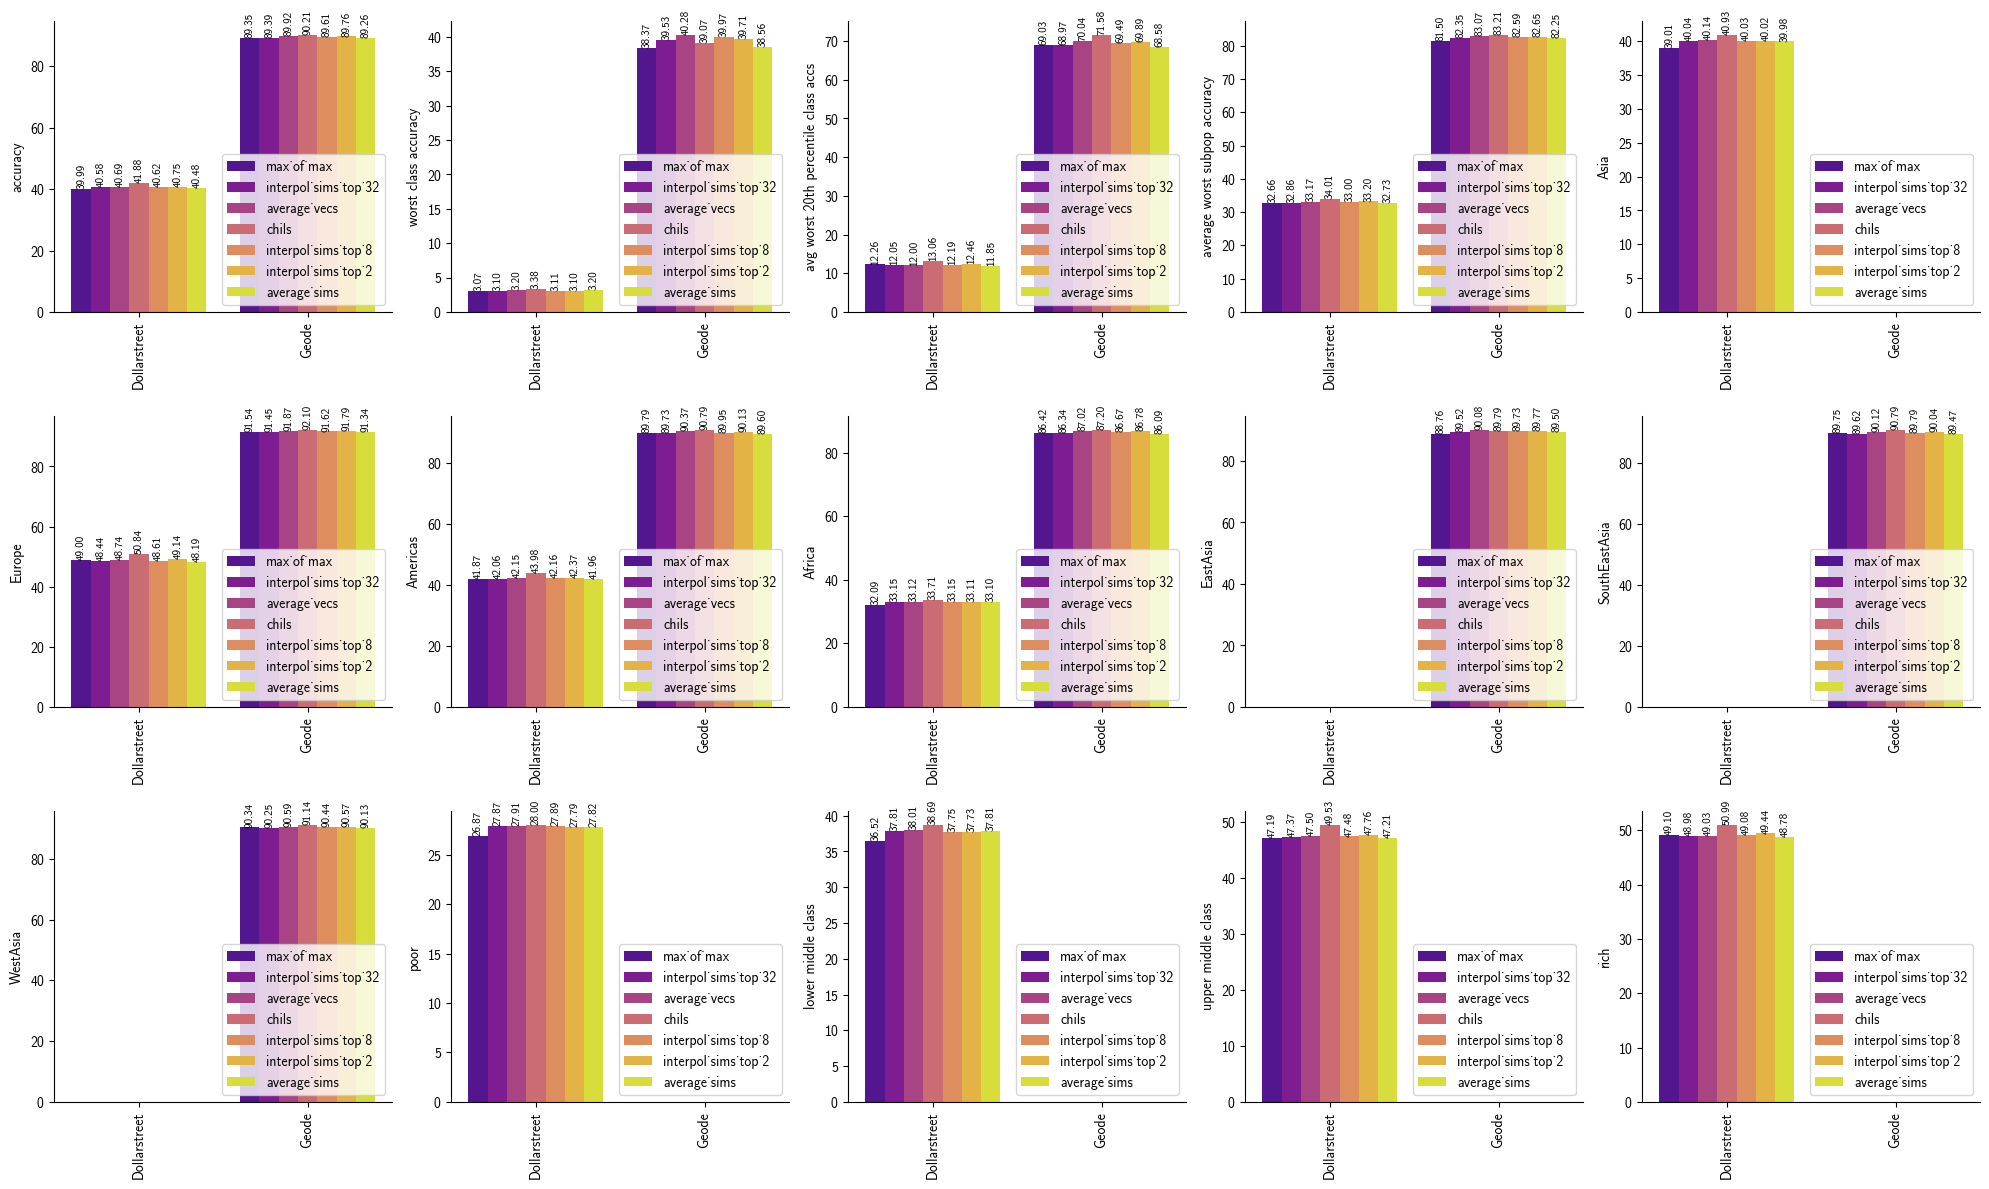

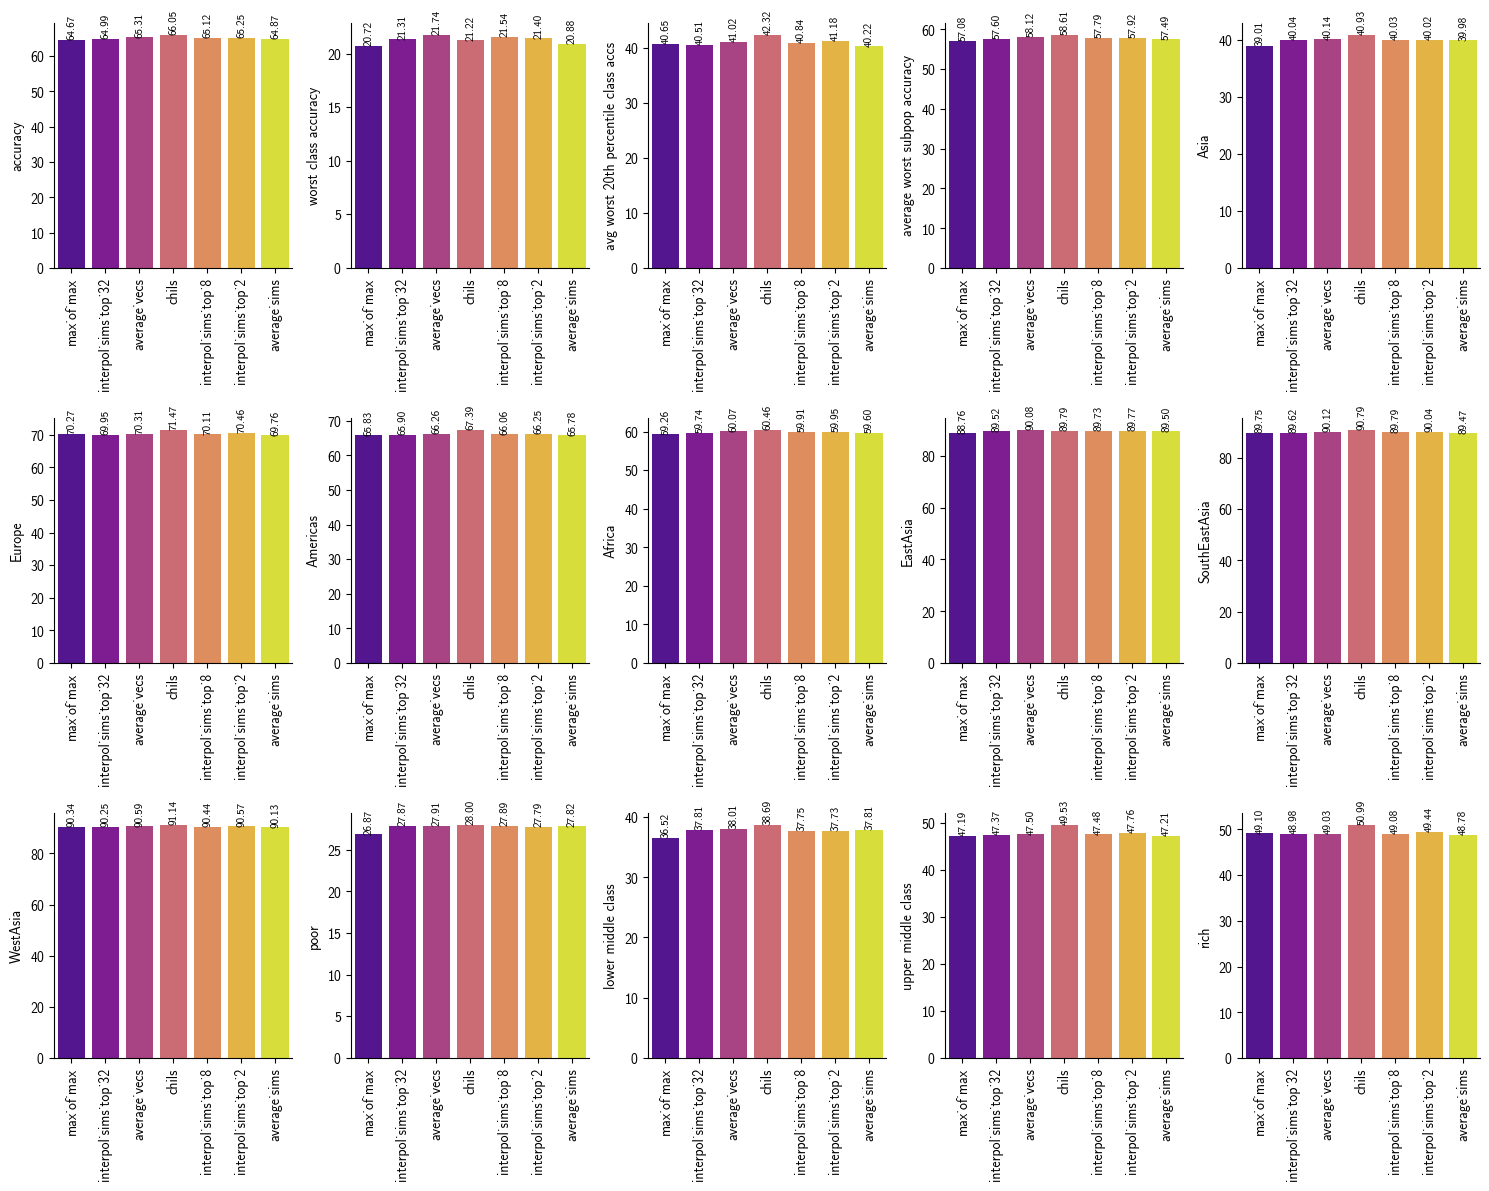

In [106]:
df = geo_df.groupby(['predictor', 'dsetname']).mean('accuracy').reset_index()
analyzer.general_plotter(
    results_df = df, 
    col_to_compare = 'predictor',
    # col_to_compare_vals = ['vanilla', 'dclip', 'chils'],
    save_fname = 'predictors_geo'
)

We can also look at our best performing guys. 

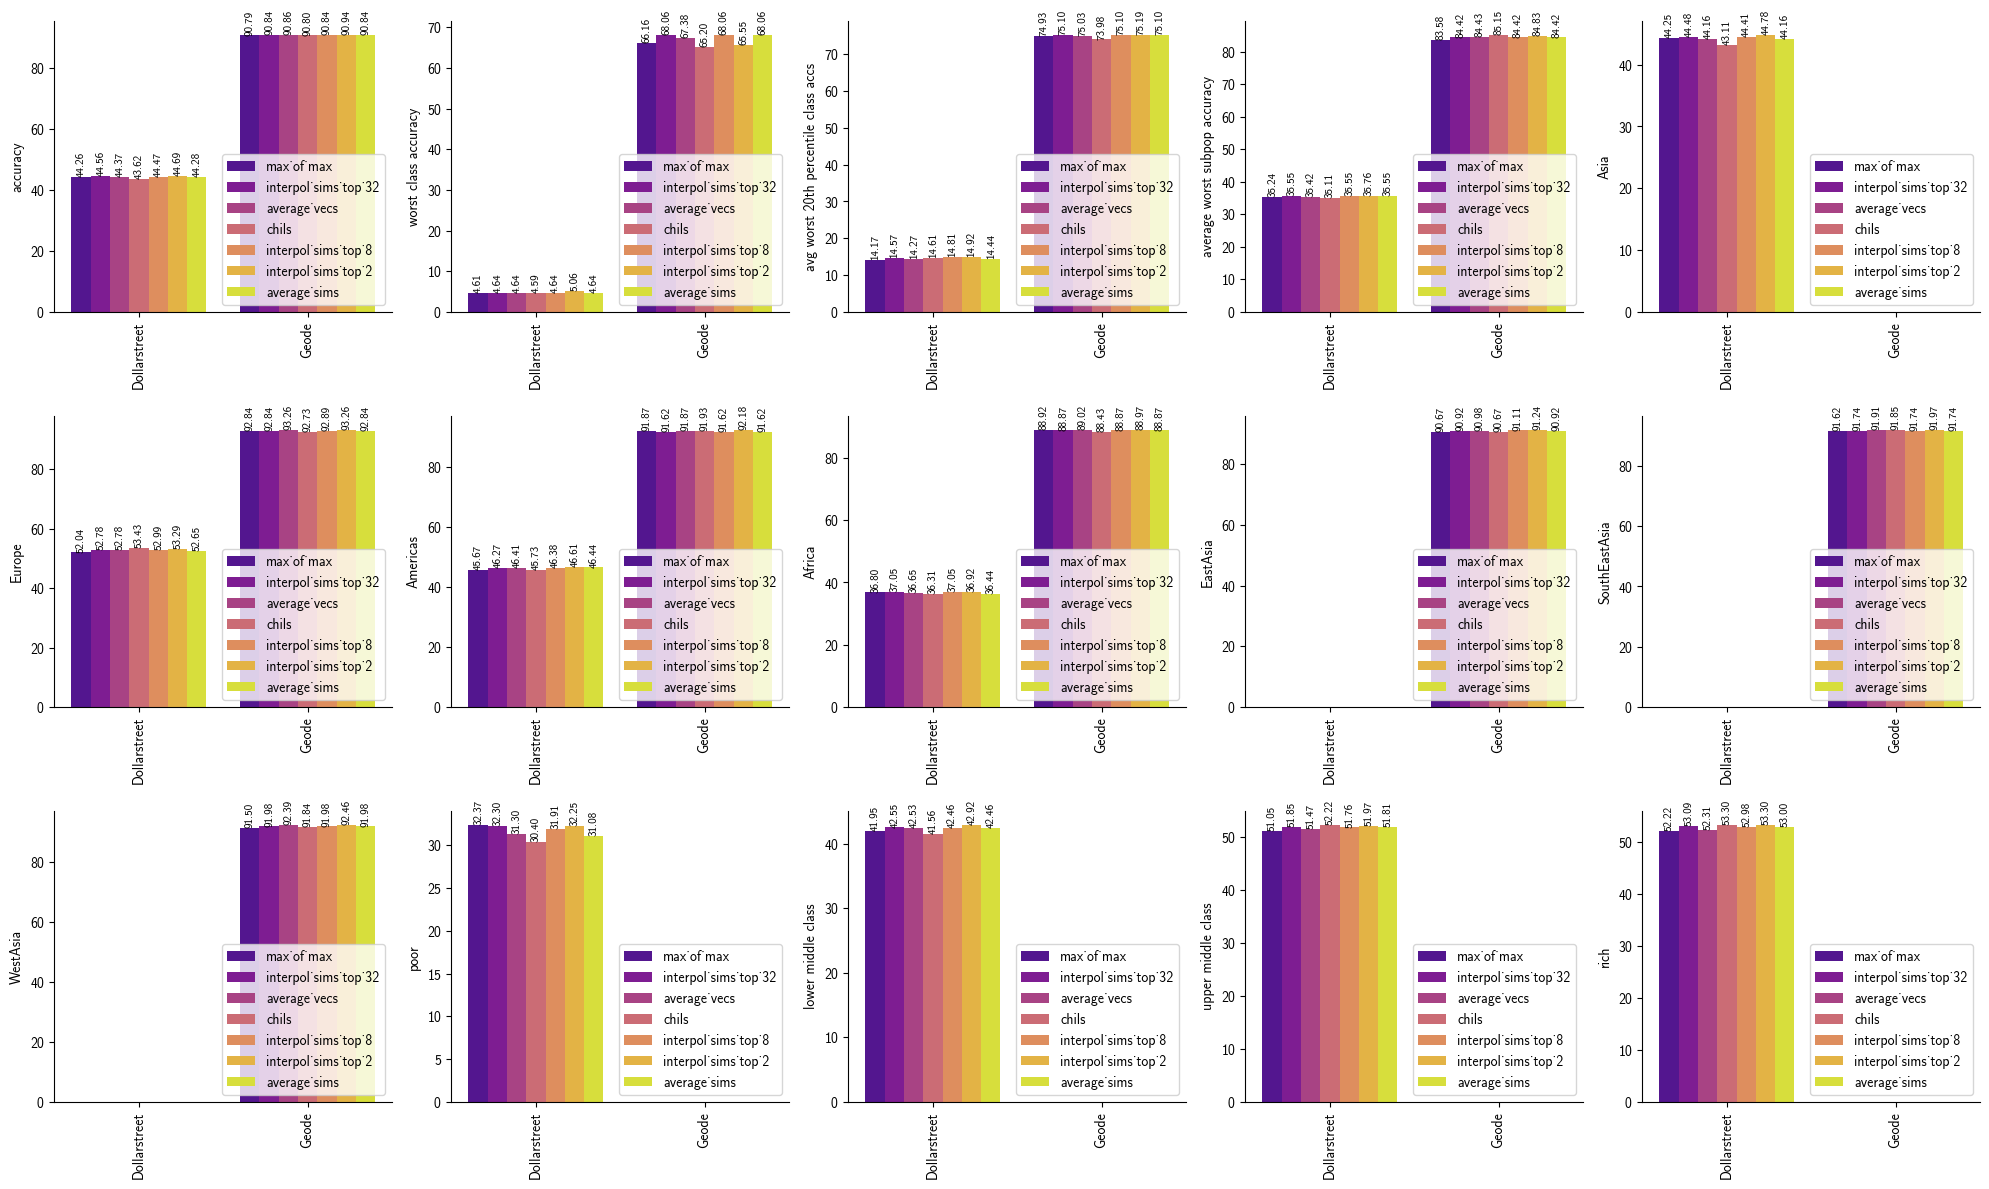

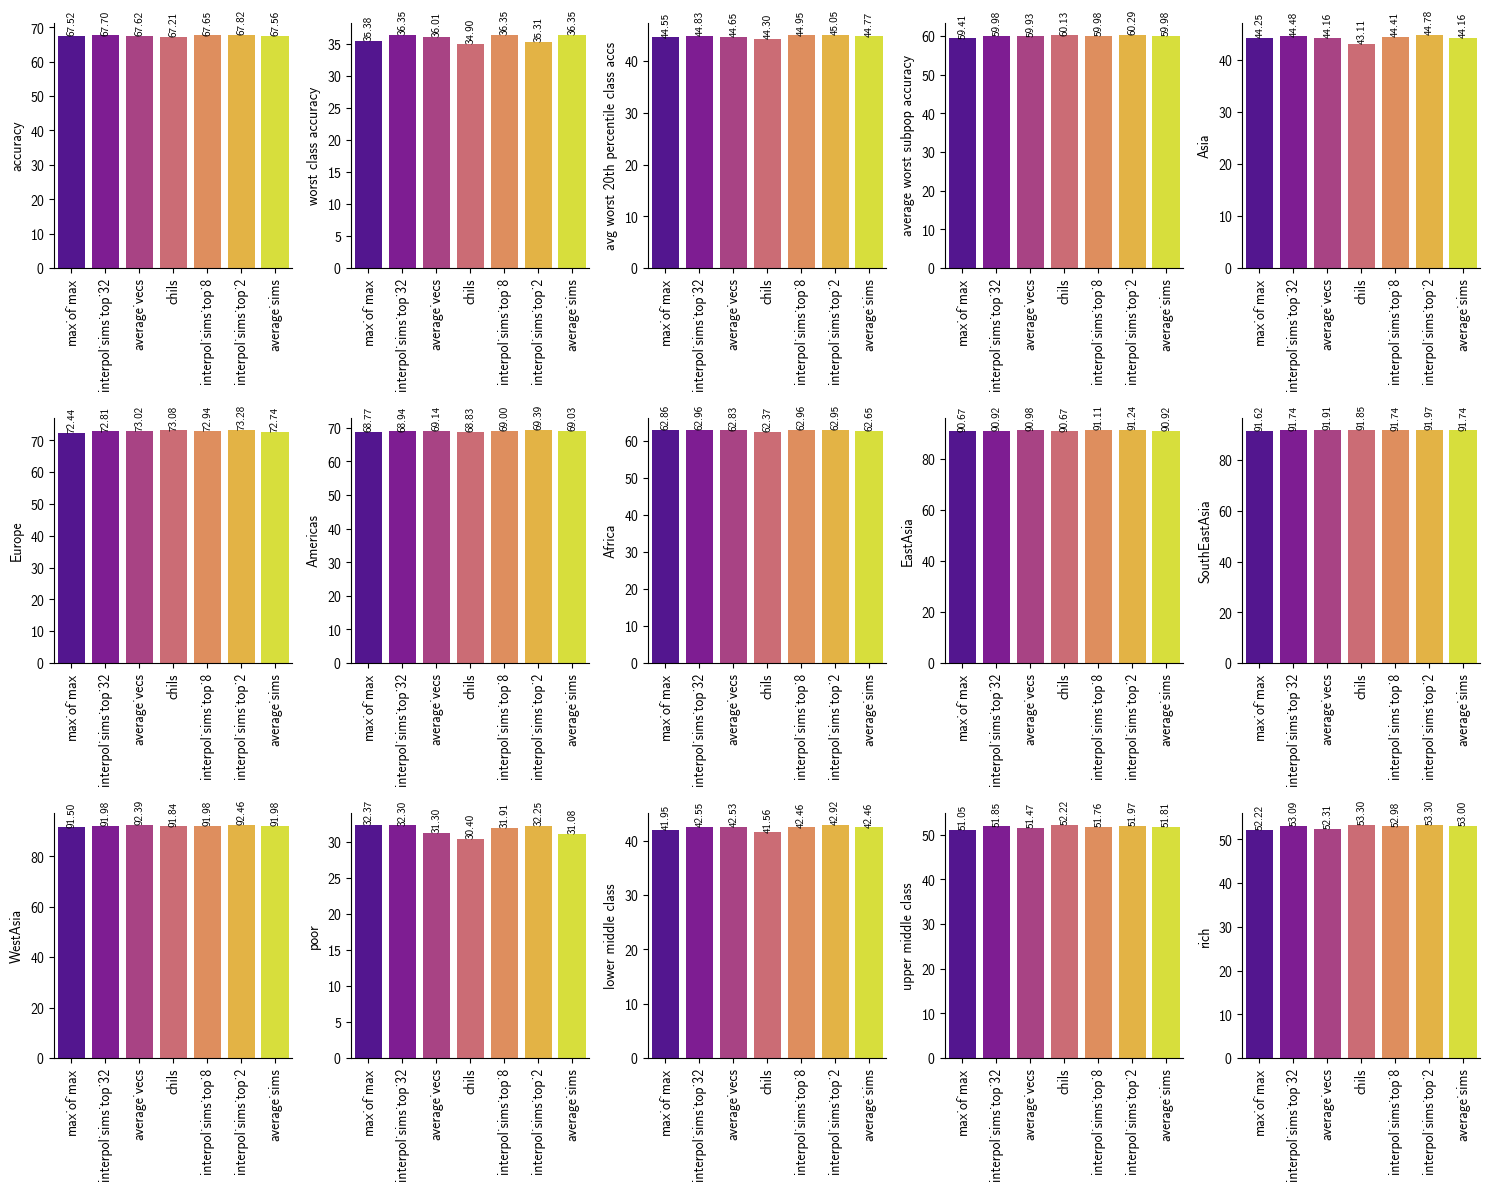

In [107]:
df = geo_df.groupby(['predictor', 'dsetname']).max('accuracy').reset_index()
analyzer.general_plotter(
    results_df = df, 
    col_to_compare = 'predictor',
    save_fname = 'predictors_geo_best'
)


In [108]:
%reload_ext autoreload

Note we don't have to plot all metrics. Here we compare attributer_keys for a few key metrics. Income level is the most helpful. 

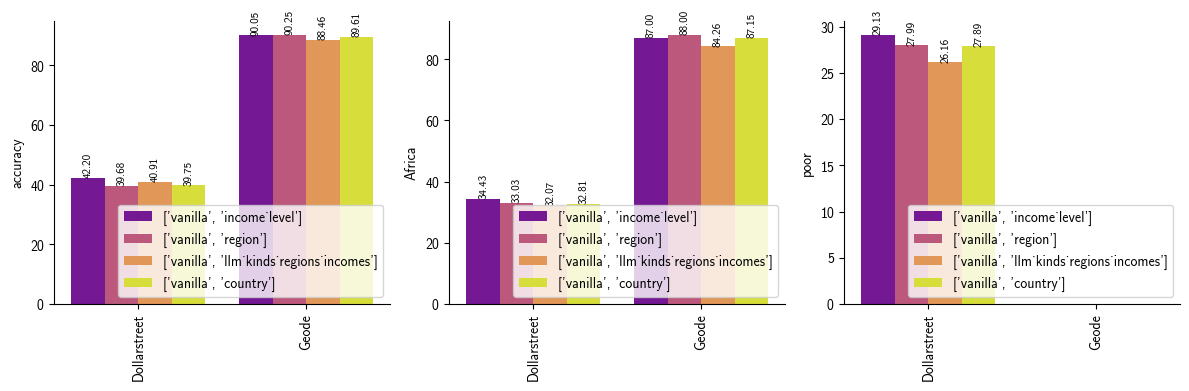

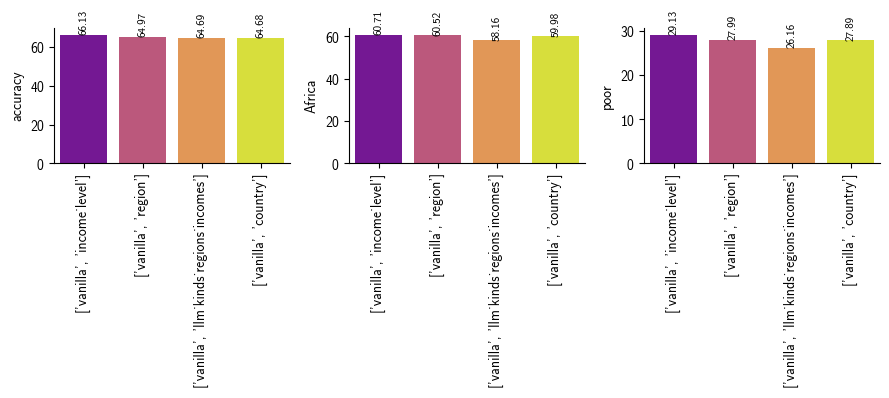

In [109]:
df = geo_df.groupby(['attributer_keys', 'dsetname']).mean('accuracy').reset_index()
analyzer.general_plotter(
    results_df = df, 
    col_to_compare = 'attributer_keys',
    metrics=['accuracy', 'Africa', 'poor'],
    save_fname = 'attributer_keys_geo'
)